# Bulk RNA-seq xQTL analysis

This notebook provide a command generator on the XQTL workflow so it can automate the work for data preprocessing and association testing on multiple data collection as proposed. This version of command generator is suitable for bed file with sQTL and eQTL, the user should specify the input and the output in a recipe file, as documented below

> ../images/eqtl_command.png (254.4 KiB):

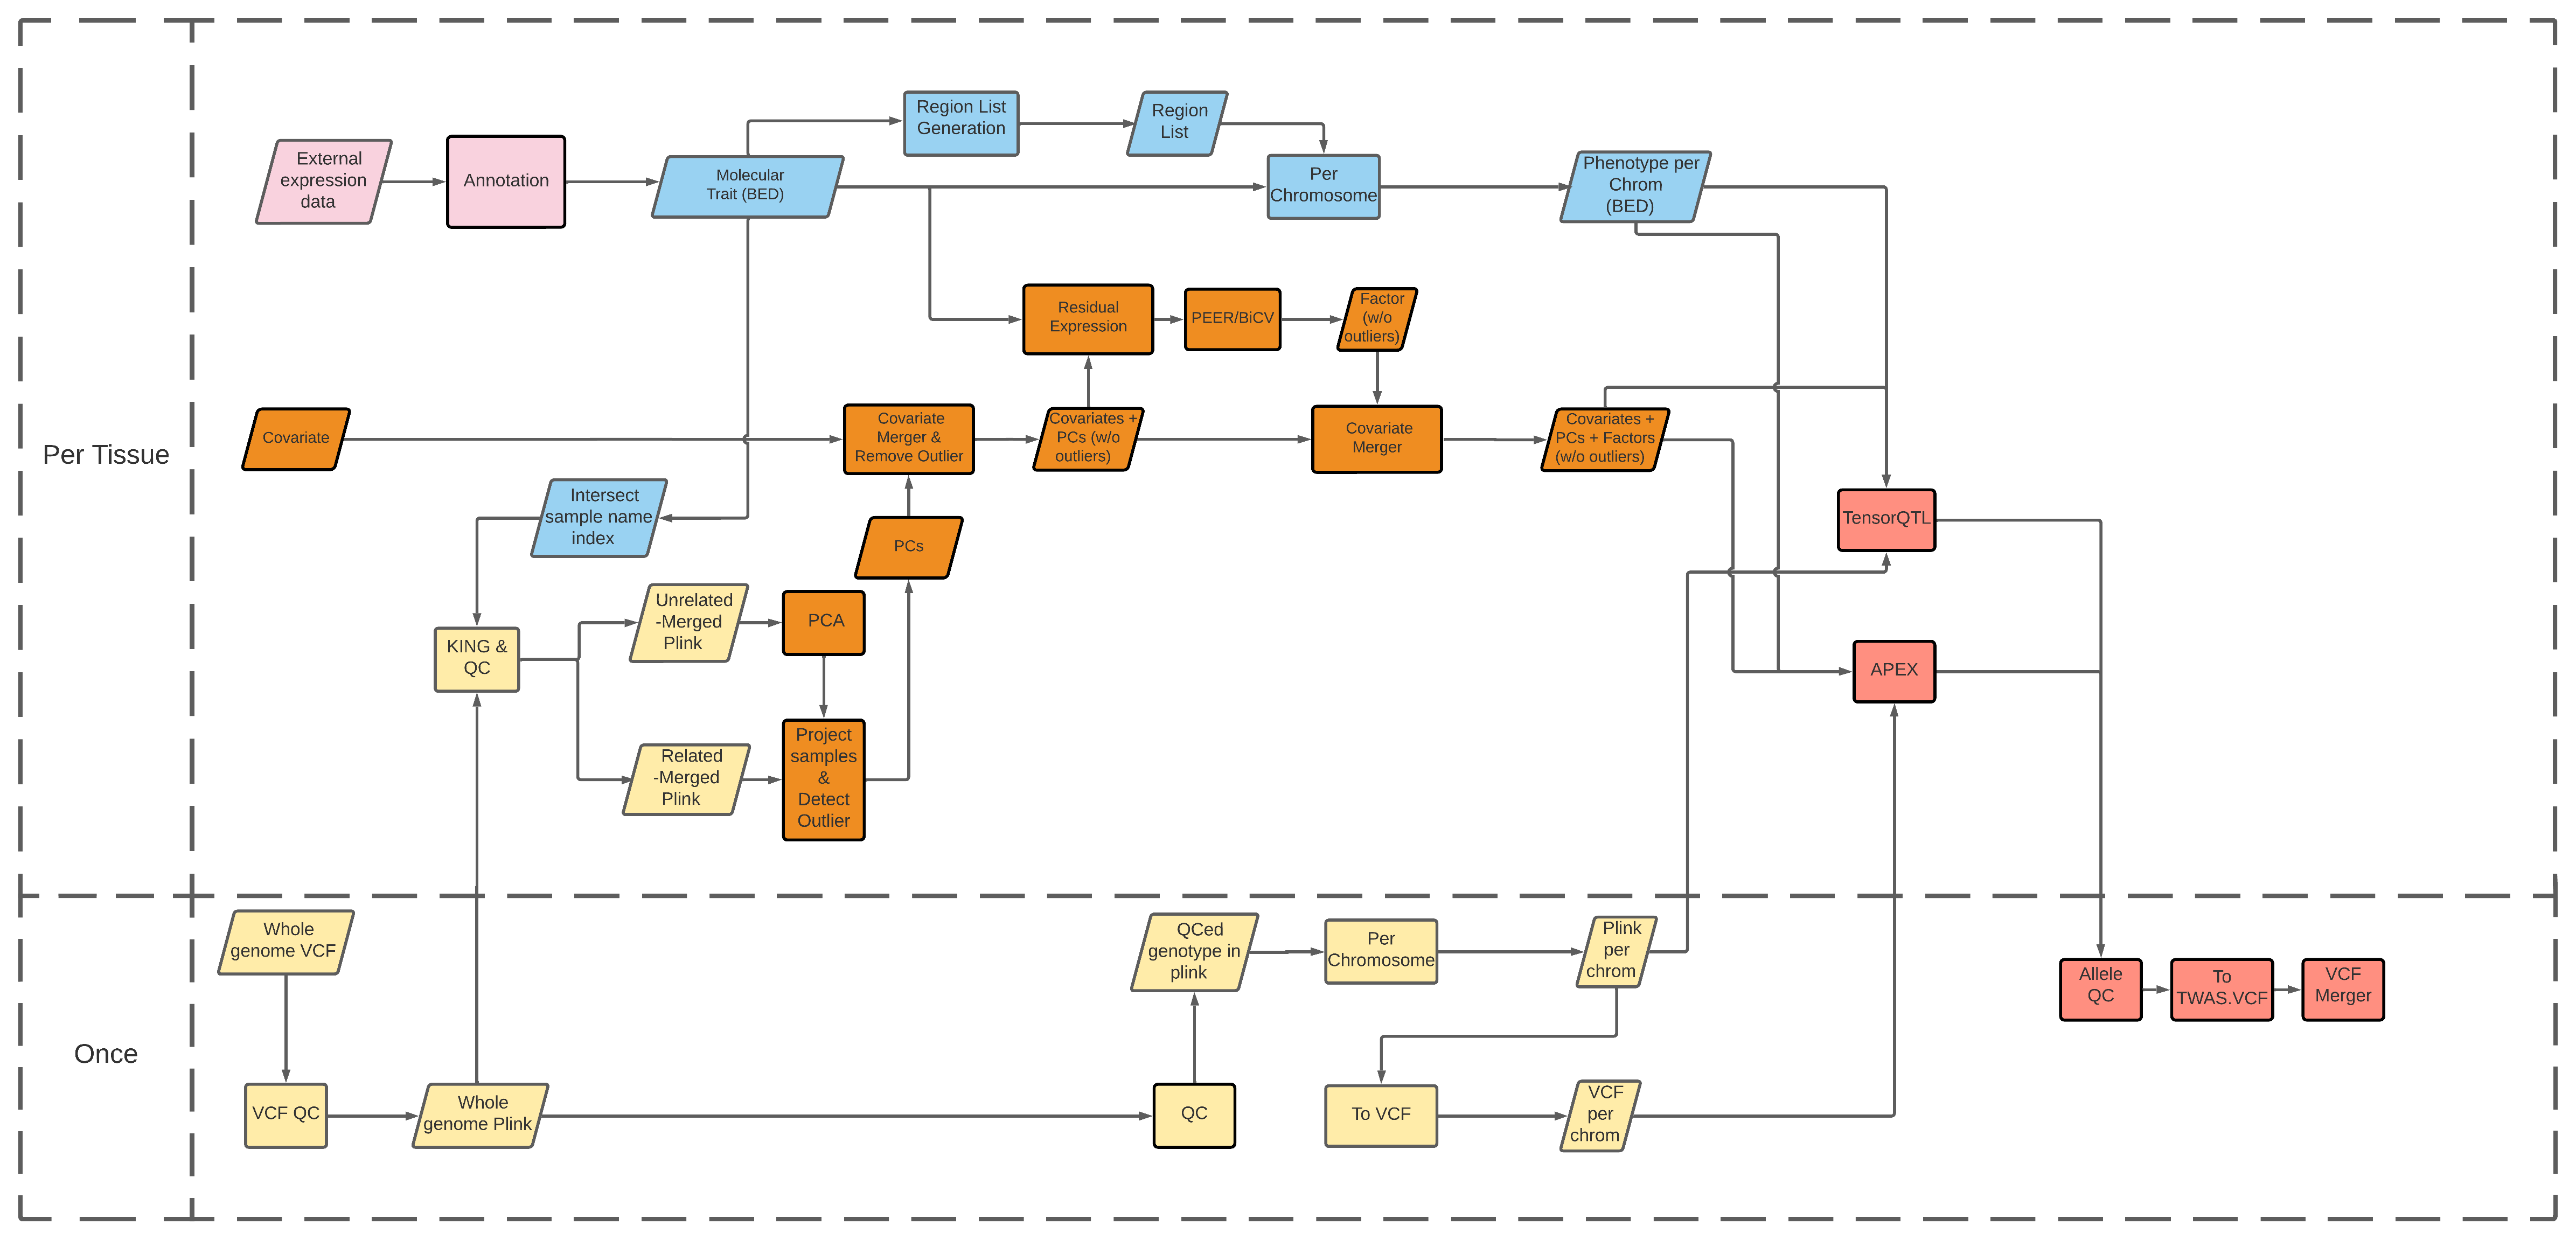

In [1]:
%preview ../images/eqtl_command.png

This master control notebook is mainly to serve the 8 tissues snuc_bulk_expression analysis, but should be functional on all analysis where expression data are are a tsv table in a bed.gz like format.

Input:

    A recipe file,each row is a data collection and with the following column:
    
        Theme
            name of dataset, must be different, each uni_study analysis will be performed in a folder named after each, meta analysis will be performed in a folder named as {study1}_{study2}
            
            The column name must contain the # and be the first column
    
        genotype_file
            {Path to a whole genome genotype file}
        
        molecular_pheno
            {Path to file}
            
        covariate_file
            {Path to file}
        
        ### note: Only data collection from the same Populations and conditions will me merged to perform Fix effect meta analysis
        
    A genotype list, with two column, `#chr` and  `path`
        
        This can be generated by the genotype session of this command generator.
     
    
Output:
    
    1 set of association_scan result for each tissue (each row in the recipe)

In [ ]:
pd.DataFrame({"Theme":"MWE","molecular_pheno":"MWE.log2cpm.tsv","genotype_file":"MWE.bed","covariate_file":"MWE.covariate.cov.gz"}).to_csv("/mnt/vast/hpc/csg/snuc_pseudo_bulk/eight_tissue_analysis/MWE/command_generator",sep = "\t",index = 0)

| Theme      | molecular_pheno | genotype_file |covariate_file| phenotype_group |
| ----------- | ----------- |-----------|----|-----| 
| eQTL      | MWE.log2cpm.bed.gz       | /data/genotype_data/GRCh38_liftedover_sorted_all.add_chr.leftnorm.filtered.bed |MWE.covariate.cov.gz|/data/genotype_data/GRCh38_liftedover_sorted_all.add_chr.leftnorm.filtered.phenotype_group |

## Minimal Working Example

### Genotype
The MWE for the genotype session can be ran with the following commands, please be noted that a [seperated MWE genoFile]( https://drive.google.com/file/d/1zaacRlZ63Nf_oEUv2nIiqekpQmt2EDch/view?usp=sharing) was needed.

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb plink_per_chrom \
    --ref_fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta    \
    --genoFile   mwe_genotype.vcf.gz  \
    --dbSNP_vcf  reference_data/00-All.vcf.gz \
    --sample_participant_lookup reference_data/sampleSheetAfterQC.txt -n 

### Per tissue analysis
A MWE for the core per tissue analysis can be ran with the following commands, a complete collection of input file as well as intermediate output of the analysis can be found at [here](https://drive.google.com/drive/folders/16ZUsciZHqCeeEWwZQR46Hvh5OtS8lFtA?usp=sharing). 

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb sumstat_standardizer \
    --recipe MWE.recipe   \
    --genotype_list plink_files_list.txt      \
    --fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta     \
    --sample_participant_lookup reference_data/sampleSheetAfterQC.txt \
    --Association_option "TensorQTL"  -n 

In [ ]:
 sos run pipeline/eQTL_analysis_commands.ipynb sumstat_standardizer    \
    --recipe MWE.recipe    \
    --genotype_list plink_files_list.txt  \
    --fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta      \
    --sample_participant_lookup reference_data/sampleSheetAfterQC.txt    \
    --Association_option "TensorQTL" --cwd output2 --run  --yml "" --N 3   

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb sumstat_merge \
    --recipe  MWE.recipe \
    --genotype_list plink_files_list.txt      \
    --annotation_gtf /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/genes.reformatted.gene.gtf     \
    --sample_participant_lookup /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/sampleSheetAfterQC.txt \
    --Association_option "APEX"   -n 

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb factor \
    --recipe  /mnt/vast/hpc/csg/xqtl_workflow_testing/methyl/recipe_PCC_methylation \
    --annotation_gtf /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/genes.reformatted.gene.gtf     \
    --sample_participant_lookup /mnt/vast/hpc/csg/xqtl_workflow_testing/methyl/Methylation_sample_list.tsv -n > Methylation_mqtl_script

## Protocol data 

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb plink_per_chrom \
    --ref_fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta    \
    --genoFile   input_data/Genotype/DEJ_11898_B01_GRM_WGS_2017-05-15_2*.recalibrated_variants.xqtl_protocol_data.add_chr.vcf.gz  \
    --dbSNP  reference_data/00-All.add_chr.variants.gz \
    --sample_participant_lookup reference_data/sample_participant_lookup.rnaseq --run --monitor

In [ ]:
 sos run pipeline/eQTL_analysis_commands.ipynb sumstat_standardizer    \
    --recipe protocol_data.recipe    \
    --genotype_list output/data_preprocessing/genotype/xqtl_protocol_data.merged.filtered.plink_files_list.txt  \
    --fasta reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta      \
    --sample_participant_lookup reference_data/sample_participant_lookup.rnaseq    \
    --Association_option "TensorQTL" --cwd output3 --run  --yml "" --N 3   --monitor

## Example for running the workflow
This will run the workflow from via several submission

In [ ]:
sos run pipeline/eQTL_analysis_commands.ipynb sumstat_merge \
    --recipe  data/recipe_8tissue_new \
    --genotype_list data/genotype_qced/plink_files_list.txt      \
    --annotation_gtf data/reference_data/genes.reformatted.gene.gtf     \
    --sample_participant_lookup data/reference_data/sampleSheetAfterQC.txt \
    --Association_option "TensorQTL"   -n &

In [ ]:
sos run ~/GIT/xqtl-pipeline/pipeline/eQTL_analysis_commands.ipynb sumstat_merge  \
    --recipe  <(cat /mnt/vast/hpc/csg/snuc_pseudo_bulk//data/recipe_8tissue_new  | head -2)    \
    --genotype_list /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/genotype_qced/plink_files_list.txt      \
    --annotation_gtf /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/genes.reformatted.gene.gtf     \
    --sample_participant_lookup /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/sampleSheetAfterQC.txt \
    --factor_option "PEER" --Association_option "TensorQTL"   -n

In [ ]:
[global]
## The aforementioned input recipe
parameter: recipe = path(".")  # Added option to run genotype part without the recipe input, which was not used.
## Overall wd, the file structure of analysis is wd/[steps]/[sub_dir for each steps]
parameter:  cwd = path("output")
## Diretory to the excutable
parameter: exe_dir = path("~/GIT/xqtl-pipeline/")
parameter: container_base_bioinfo = 'containers/bioinfo.sif'
parameter: container_apex = 'containers/apex.sif'
parameter: container_PEER = 'containers/PEER.sif'
parameter: container_TensorQTL = 'containers//TensorQTL.sif'
parameter: container_rnaquant = 'containers/rna_quantification.sif'
parameter: container_flashpca = 'containers/flashpcaR.sif'
parameter: container_susie = 'containers/stephenslab.sif'
parameter: phenotype_id_type = "gene_name" 
parameter: yml = path("csg.yml")
parameter: run = False
parameter: monitor = False
interpreter = 'cat' if not run else 'bash'
import pandas as pd
if recipe.is_file():
    input_inv = pd.read_csv(recipe, sep = "\t").to_dict("records")
import os
parameter: jobs = 50 # Number of jobs that are submitted to the cluster
parameter: queue = "csg2" # The queue that jobs are submitted to
submission = f'-J {jobs} -c {yml} -q {queue}'
parameter: mem = "16G"
## Control of the workflow
### Factor option (PEER vs BiCV)
parameter: factor_option = "PEER"
### Association scan option (APEX vs TensorQTL)
parameter: Association_option = "TensorQTL"

## Data Preprocessing
### Genotype Preprocessing (Once for all tissues)

In [ ]:
[VCF_QC]
parameter: genoFile = paths
parameter: ref_fasta = path
parameter: add_chr = True
parameter: dbSNP = path
input: genoFile, group_by = 1
output: f'{cwd}/data_preprocessing/genotype/{_input[0]:bnn}.{"add_chr." if  add_chr else False}leftnorm.filtered.bed'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
       $["monitor.py" if monitor else ""] sos run $[exe_dir]//pipeline/VCF_QC.ipynb qc \
            --genoFile $[_input[0]] \
            --dbsnp-variants $[dbSNP] \
            --reference-genome $[ref_fasta] \
            --cwd $[_output:d] \
            --container $[container_base_bioinfo] \
            --walltime "24h" \
            $[submission if yml.is_file() else "" ] $["--add_chr" if add_chr else "--no-add_chr"  ]

In [ ]:
[merge_plink]
parameter: genoFile = paths
skip_if(len(genoFile) == 1)
input: output_from("VCF_QC"), group_by = "all"
parameter: name = "xqtl_protocol_data.merged"
output: f"{cwd}/data_preprocessing/genotype//{name}.bed"
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
 $["monitor.py" if monitor else ""] sos run $[exe_dir]//pipeline/genotype_formatting.ipynb merge_plink \
            --genoFile $[_input:r] \
            --cwd $[_output:d] --name $[name] \
            --container $[container_base_bioinfo]  $[submission if yml.is_file() else "" ]

In [ ]:
[plink_QC]
# minimum MAF filter to use. 0 means do not apply this filter.
parameter: maf_filter = 0
# minimum MAC filter to use. 0 means do not apply this filter.
parameter: mac_filter = 5
# maximum MAF filter to use. 0 means do not apply this filter.
parameter: maf_max_filter = 0.0
# Maximum missingess per-variant
parameter: geno_filter = 0.1
# Maximum missingness per-sample
parameter: mind_filter = 0.1
# HWE filter 
parameter: hwe_filter = 1e-06
# MAC filter
parameter: mac_filter = 5
parameter: genoFile = paths

input: (output_from("VCF_QC") if len(genoFile) == 1 else output_from("merge_plink"))
output: f'{_input:n}.filtered.bed'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
        $["monitor.py" if monitor else ""] sos run $[exe_dir]//pipeline/GWAS_QC.ipynb qc_no_prune \
            --cwd $[_output:d] \
            --genoFile $[_input] \
            --maf-filter $[maf_filter] \
            --mac_filter $[0 if maf_filter else mac_filter] \
            --geno-filter $[geno_filter] \
            --mind-filter $[mind_filter] \
            --hwe-filter $[hwe_filter]   \
            --mem  $[mem]  \
            --container $[container_base_bioinfo]  $[submission if yml.is_file() else "" ]

In [ ]:
[plink_per_chrom]
input: output_from("plink_QC")
output: f'{cwd}/data_preprocessing//genotype/{_input:bn}.plink_files_list.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
        $["monitor.py" if monitor else ""] sos run $[exe_dir]//pipeline/genotype_formatting.ipynb plink_by_chrom \
            --genoFile $[_input] \
            --cwd $[_output:d] \
            --chrom  `cut -f 1  $[_input:n].bim  | uniq | sed "s/chr//g"` \
            --container $[container_base_bioinfo]  $[submission if yml.is_file() else "" ]

In [ ]:
[plink_to_vcf]
parameter: genotype_list = path
input: genotype_list
import pandas as pd
parameter: genotype_file_name = pd.read_csv(_input,"\t",nrows = 1).values.tolist()[0][1]
output: f'{cwd}/data_preprocessing//genotype/{path(genotype_file_name):bnn}.vcf_files_list.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
        $["monitor.py" if monitor else ""] sos run $[exe_dir]//pipeline/genotype_formatting.ipynb plink_to_vcf \
            --genoFile $[_input] \
            --cwd $[_output:d] \
            --container $[container_base_bioinfo]  $[submission if yml.is_file() else "" ]

In [ ]:
[plink_per_gene]
# The plink genotype file
parameter: genoFile = path
input: output_from("region_list_concat"),genoFile
output: f'{cwd}/data_preprocessing/genotype/{_input[1]:bn}.plink_files_list.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
        $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline//genotype_formatting.ipynb plink_by_gene \
            --genoFile $[_input[1]] \
            --cwd $[_output:d] \
            --region_list  $[_input[0]] \
            --container $[container_base_bioinfo]  $[submission if yml.is_file() else "" ]

### Molecular Phenotype Processing

In [ ]:
[phenotype_partition_by_chrom]
parameter: region_list = path() 
input: for_each = "input_inv"
output: per_chrom_pheno_list = f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/phenotype_data/{path(_input_inv["molecular_pheno"]):bn}.per_chrom.recipe'        
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/phenotype_formatting.ipynb partition_by_chrom \
        --cwd $[_output:d]  \
        --phenoFile $[path(_input_inv["molecular_pheno"]):a] \
        --region-list  $[region_list if region_list.is_file() else f'<(zcat {path(_input_inv["molecular_pheno"]):a}  | cut -f 1,2,3,4)']  \
        --container $[container_rnaquant] \
        $[f'--mem {mem}' if yml.is_file() else "" ]       $[submission if yml.is_file() else "" ]

### Genotype Processing
Since genotype is shared among the eight tissue, the QC of whole genome file is not needed. Only pca needed to be run again.

In [ ]:
[sample_match]
parameter: sample_participant_lookup = path
input: for_each = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/{sample_participant_lookup:bn}.filtered.txt',
        geno = f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/{sample_participant_lookup:bn}.filtered_geno.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/sample_matcher.ipynb filtered_sample_list \
        --cwd $[_output[0]:d]  \
        --phenoFile $[_input_inv["molecular_pheno"]]  \
        --genoFile $[path(_input_inv["genotype_file"]):n].fam  \
        --sample-participant-lookup $[sample_participant_lookup] \
        --container $[container_base_bioinfo] \
        --translated_phenoFile $[submission if yml.is_file() else "" ]

In [ ]:
[king]
parameter: sample_participant_lookup = path
parameter: maximize_unrelated = False
input:output_from("sample_match")["geno"], group_with = "input_inv"
output: related = f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/genotype_data/{path(_input_inv["genotype_file"]):bn}.{_input_inv["Theme"]}.related.bed',
        unrelated = f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/genotype_data/{path(_input_inv["genotype_file"]):bn}.{_input_inv["Theme"]}.unrelated.bed'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
 $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/GWAS_QC.ipynb king \
    --cwd $[_output[0]:d] \
    --genoFile $[_input_inv["genotype_file"]] \
    --name $[_input_inv["Theme"]] \
    --keep-samples $[_input] \
    --container $[container_base_bioinfo] \
    --walltime 48h  $[submission if yml.is_file() else "" ] $["--maximize_unrelated" if maximize_unrelated else "--no-maximize_unrelated"]

In [ ]:
[unrelated_QC]
input: output_from("king")["unrelated"]
output: unrelated_bed = f'{_input:n}.filtered.prune.bed', 
        prune = f'{_input:n}.filtered.prune.in'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
 $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/GWAS_QC.ipynb qc \
    --cwd $[_output[0]:d] \
    --genoFile $[_input] \
    --exclude-variants /mnt/vast/hpc/csg/snuc_pseudo_bulk/Ast/genotype/dupe_snp_to_exclude \
    --mac-filter 5 \
    --container $[container_base_bioinfo] \
    $[f'--mem {mem}' if yml.is_file() else "" ]   $[submission if yml.is_file() else "" ] 

In [ ]:
[related_QC]
input: output_from("king")["related"],output_from("unrelated_QC")["prune"]
output: f'{_input[0]:n}.filtered.extracted.bed'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
 $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/GWAS_QC.ipynb qc_no_prune \
    --cwd $[_output[0]:d] \
    --genoFile $[_input[0]] \
    --maf-filter 0 \
    --geno-filter 0 \
    --mind-filter 0.1 \
    --hwe-filter 0 \
    --keep-variants $[_input[1]]  \
    --container $[container_base_bioinfo]  \
    $[f'--mem {mem}' if yml.is_file() else "" ]    $[submission if yml.is_file() else "" ]

## Factor Analysis

In [ ]:
[pca]
input: output_from("unrelated_QC")["unrelated_bed"],group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/pca/{_input:bn}.pca.rds',
        f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/pca/{_input:bn}.pca.scree.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
     $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/PCA.ipynb flashpca \
        --cwd $[_output:d] \
        --genoFile $[_input] \
        --container $[container_flashpca]  $[submission if yml.is_file() else "" ]

In [ ]:
[projected_sample]
# The percentage of PVE explained
parameter: PVE_treshold = 0.7
input: output_from("related_QC"),output_from("pca"), group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/pca/{_input[0]:bn}.pca.projected.rds',
        f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/pca/{_input[0]:bn}.pca.projected.scree.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/PCA.ipynb project_samples \
            --cwd $[_output:d] \
            --genoFile $[_input[0]] \
            --pca-model  $[_input[1]] \
            --maha-k `awk '$3 < $[PVE_treshold]' $[_input[2]] | tail -1 | cut -f 1  ` \
            --container $[container_flashpca]  $[submission if yml.is_file() else "" ]

In [ ]:
[merge_pca_covariate]
# The percentage of PVE explained
parameter: PVE_treshold = 0.7
input: output_from("projected_sample"),group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/covariates/{path(_input_inv["covariate_file"]):bn}.pca.gz'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/covariate_formatting.ipynb merge_pca_covariate \
            --cwd $[_output:d] \
            --pcaFile $[_input[0]:a] \
            --covFile  $[path(_input_inv["covariate_file"])] \
            --tol_cov 0.3  \
            --k `awk '$3 < $[PVE_treshold]' $[_input[1]] | tail -1 | cut -f 1 ` \
            --container $[container_base_bioinfo] $[submission if yml.is_file() else "" ] --name $[_output:bn] --outliersFile $[_input[0]:an].outliers

In [ ]:
[resid_exp]
input: output_from("merge_pca_covariate"),group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/resid_phenotype/{path(_input_inv["molecular_pheno"]):bnn}.cov_pca.resid.bed.gz'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""]  sos run $[exe_dir]/pipeline/covariate_formatting.ipynb compute_residual \
            --cwd $[_output:d] \
            --phenoFile $[path(_input_inv["molecular_pheno"]):a] \
            --covFile  $[_input[0]:a] \
            --container $[container_base_bioinfo] $[submission if yml.is_file() else "" ] --name $[_output:bnnn]

In [ ]:
[factor]
parameter: N = 0
input: output_from("resid_exp"),group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/covariates/{_input[0]:bnn}.{factor_option}.gz'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
         $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/$[factor_option]_factor.ipynb $[factor_option] \
            --cwd $[_output:d] \
            --phenoFile $[_input[0]:a]  \
            --container $[container_apex if factor_option == "BiCV" else container_PEER]  \
            --walltime 24h \
            --numThreads 8 \
            --iteration 1000 \
            --N $[N]  $[submission if yml.is_file() else "" ]

In [ ]:
[merge_factor_covariate]
# The percentage of PVE explained
parameter: PVE_treshold = 0.7
input: output_from("factor"),output_from("merge_pca_covariate"),group_with = "input_inv"
output: f'{cwd}/data_preprocessing/{_input_inv["Theme"]}/covariates/{_input[0]:bn}.cov.gz'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output}.step_{step_name}.stderr', stdout = f'{_output}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/covariate_formatting.ipynb merge_factor_covariate \
            --cwd $[_output:d] \
            --factorFile $[_input[0]:a] \
            --covFile  $[_input[1]:a] \
            --container $[container_base_bioinfo] $[submission if yml.is_file() else "" ] --name $[_output:bn]

## Association Scan

In [ ]:
[TensorQTL]
# The number of minor allele count as treshold for the analysis
parameter: MAC = 0
# The minor allele frequency as treshold for the analysis, overwrite MAC
parameter: maf_threshold = 0
parameter: genotype_list = path
parameter: cis_window = 1000000
parameter: mem = "50G"
input: genotype_list, output_from("phenotype_partition_by_chrom"),output_from("merge_factor_covariate"),group_with = "input_inv"
output: f'{cwd:a}/association_scan/{_input_inv["Theme"]}/TensorQTL/TensorQTL.cis._recipe.tsv'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/TensorQTL.ipynb cis \
        --genotype-file $[_input[0]]   \
        --phenotype-file $[_input[1]] \
        --covariate-file $[_input[2]]    \
        --cwd $[_output:d]  \
        --window $[cis_window] \
         $[submission if yml.is_file() else "" ] $[f'--mem {mem}' if yml.is_file() else "" ] \
         $[f'--MAC {MAC}' if MAC else ""]  \
         $[f'--maf_threshold {maf_threshold}' if maf_threshold else ""] \
         $[f'--phenotype_group {_input_inv["phenotype_group"]}' if _input_inv["phenotype_group"] else "" ] \
        --container $[container_TensorQTL]  

In [ ]:
[APEX]
parameter: genotype_list = path
input: output_from("plink_to_vcf"), output_from("phenotype_partition_by_chrom"),output_from("merge_factor_covariate"),group_with = "input_inv"
output: f'{cwd:a}/association_scan/{_input_inv["Theme"]}/APEX/APEX_QTL_recipe.tsv'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/APEX.ipynb cis \
        --genotype-list $[_input[0]]   \
        --phenotype-list $[_input[1]] \
        --covariate-file $[_input[2]]    \
        --cwd $[_output:d]  \
        --container $[container_apex] $[submission if yml.is_file() else "" ] --name $[_input[1]:bnn]

## Trans Association Scan

In [ ]:
[TensorQTL_Trans]
parameter: MAC = 0
# The minor allele frequency as treshold for the analysis, overwrite MAC
parameter: maf_threshold = 0
parameter: genotype_list = path
parameter: region_list = path
input: genotype_list, output_from("phenotype_partition_by_chrom"),output_from("merge_factor_covariate"),group_with = "input_inv"
output: f'{cwd:a}/association_scan/{_input_inv["Theme"]}/Trans/TensorQTL.trans._recipe.tsv'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
    $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/TensorQTL.ipynb trans \
        --genotype-list $[_input[0]]   \
        --phenotype-list $[_input[1]] \
        --covariate-file $[_input[2]]    \
        --cwd $[_output:d]  \
        --region_list $[region_list] \
        --container $[container_TensorQTL] $[submission if yml.is_file() else "" ] $[f'--MAC {MAC}' if MAC else ""] $[f'--maf_threshold {maf_threshold}' if maf_threshold else ""]

## Sumstat Merger

In [ ]:
[yml_generation]
parameter: TARGET_list = path("./")
input: output_from(Association_option), group_by = "all"
output: f'{cwd:a}/data_intergration/{Association_option}/qced_sumstat_list.txt',f'{cwd:a}/data_intergration/{Association_option}/yml_list.txt'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{_output[0]}.step_{step_name}.stderr', stdout = f'{_output[0]}.stdout'
        $["monitor.py" if monitor else ""] sos run $[exe_dir]/pipeline/yml_generator.ipynb yml_list \
            --sumstat-list $[_input] \
            --cwd  $[_output[1]:d] --name $[" ".join([str(x).split("/")[-3] for x in _input])]  

In [ ]:
[target_generation]
parameter: fasta = "reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta"
parameter: mem = "50G"
input: output_from("yml_generation")
output: f'{_input[0]:d}/TARGET.ref.list'
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{step_name}.step_{step_name}.stderr', stdout = f'{step_name}.stdout'
      $["monitor.py" if monitor else ""] sos run  $[exe_dir]/pipeline/summary_stats_standardizer.ipynb TARGET_generation  \
            --fasta $[fasta] \
            --sumstat-list $[_input[0]]    \
            --yml-list $[_input[1]]    \
            --cwd $[_input[0]:d]  $[submission if yml.is_file() else "" ] $[f'--mem {mem}' if yml.is_file() else "" ]  --walltime 48h --container $[container_base_bioinfo]


In [ ]:
[sumstat_standardizer]
parameter: mem = "50G"
input: output_from("yml_generation"), output_from("target_generation")
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{step_name}.step_{step_name}.stderr', stdout = f'{step_name}.stdout'
      $["monitor.py" if monitor else ""] sos run  $[exe_dir]/pipeline/summary_stats_standardizer.ipynb sumstat_standardization  \
            --sumstat-list $[_input[0]]    \
            --yml-list $[_input[1]]    \
            --TARGET_list $[_input[2]] \
            --cwd $[_input[0]:d]  $[submission if yml.is_file() else "" ] $[f'--mem {mem}' if yml.is_file() else "" ]  --walltime 48h --container $[container_base_bioinfo]

In [ ]:
[sumstat_to_vcf]
parameter: mem = "50G"
input: output_from("yml_generation")
depends: sos_step('sumstat_standardizer')
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{step_name}.step_{step_name}.stderr', stdout = f'{step_name}.stdout'
      $["monitor.py" if monitor else ""] sos run  $[exe_dir]/pipeline/summary_stats_standardizer.ipynb sumstat_to_vcf  \
            --sumstat-list $[_input[0]]    \
            --cwd $[_input[0]:d]  $[submission if yml.is_file() else "" ] $[f'--mem {mem}' if yml.is_file() else "" ]  --walltime 48h --container $[container_base_bioinfo]

In [ ]:
[assoc_result_proc]
input: output_from("yml_generation")
depends: sos_step('sumstat_to_vcf')
script: interpreter = interpreter, expand = "$[ ]", stderr = f'{step_name}.step_{step_name}.stderr', stdout = f'{step_name}.stdout'
    $["monitor.py" if monitor else ""] sos run  $[exe_dir]/pipeline/assoc_result_processing.ipynb genome  \
        --vcf `ls $[_input[0]:d]/*/*cis_long_table.vcf` \
        --padjust-method "bonferroni"      \
        --container $[container_base_bioinfo] \
        $[f'--mem {mem}' if yml.is_file() else "" ]   $[submission if yml.is_file() else "" ] 